In [3]:
import datetime
import scipy as scp
import numpy as np
import sklearn.metrics 
import pickle
from scipy.integrate import simps

import warnings

import h5py

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

import matplotlib.gridspec as gridspec


from samplingv4 import makeSS

In [2]:
"""
load data
"""

filename = '../data/cell1.hdf5'
f = h5py.File(filename, 'r')

for item in f.attrs:
    print(item, f.attrs[item])
    
stim_binary = f['stim_binary'][:]
stim_gauss = f['stim_gauss'][:]

r_binary = f['r_binary'][:]
r_gauss = f['r_gauss'][:]

f.close()


# choose data
light = stim_binary
data = r_binary

# stim time with time resolution of dt =1ms
stimT = np.arange(0, len(light),1)/1000

stim_binary_binned = stim_binary[::10]

dt[ms] for r = 10
dt[ms] for stim = 1
info: Stim and vesicle release of one cell, 4 recordings per stim, binned sum for r but raw for stim (dt=1)


## glmnet

In [11]:
import glmnet_python
from glmnet import glmnet


In [6]:
import glmnet_python
from glmnet import glmnet

import sys
sys.path.append('../test')
sys.path.append('../lib')
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

# parameters
baseDataDir= '/glmnet_python/data/'



In [4]:
"""
construct data
"""

def get_datax(data, tau, offset=0):
    """
    produces shifted copies of data
    with tau depth
    offset: include current timepoint or not # handle with care
    """
    X = np.zeros((tau, len(data)-tau))

    for i in range(0,tau):
        X[i][:] = data[tau-i-offset:len(data)-i-offset]
    return X.T



def get_datax_new(data, tau):
    """
    produces shifted copies of data
    with tau depth
    """
    X = np.zeros((len(data)-tau, tau))
    #print(np.shape(X))
    
    for i in range(len(data)-tau):
        X[:][i] = data[i:i+tau]
    return X


trialnr = 1


# get stim component 
## including the current stimulus to predict (present)
tau_stim = 11#tau
x_stim = get_datax_new(stim_binary_binned, tau_stim)

# get release component
## only including the past
tau_r = 10#tau
# taking one data trace
x_r = get_datax_new(r_binary[trialnr], tau_r)[:-1] 
# taking mean 
#x_r = get_datax(np.mean(r_binary, axis=0), tau_r)

x = np.hstack([x_stim, x_r])#[:-1]

# taking one data trace
y = np.array(r_binary[trialnr])[tau_stim:]

# taking mean
#y = np.array(np.mean(r_binary, axis=0))[tau+1:]


In [ ]:
"""
fit the model
"""
#offset = np.ones(len(y))
alpha = 0 # 1 is lasso, 0 is ridge 

fit = glmnet(x = x.copy(), y = y.copy(), family = 'poisson', alpha=alpha)#, offset=offset.copy())

In [67]:
s = [0.02]

coeff = glmnetCoef(fit, s = scipy.float64([s[0]]), exact = False)


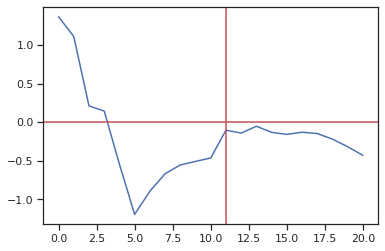

In [69]:
plt.plot(coeff[1:])
plt.axvline(11, color='r')

plt.axhline(0, color='r')

In [71]:
"""
reconstruction
"""
#That is, 
#* “link” (default) gives the linear predictors like others 
#* “response” gives the fitted mean 
#* “coefficients” computes the coefficients at the requested values for s

fc = glmnetPredict(fit, 
                   x.copy(),
                   #offset= np.array([offset]).T,
                   ptype = 'response',
                   s = scipy.float64([s[0]]))

In [77]:
release_pred = np.zeros(len(r_binary[0])-tau_stim)


In [82]:
np.shape(x[:tau_stim])

(11, 21)

In [103]:
"""
run one evaluation
"""

# define variables
release_pred = np.zeros(len(r_binary[0])-tau_stim)
rate_pred = np.zeros(len(release_pred))

# get initial prediction
init_predict =  glmnetPredict(fit, 
                   x.copy()[:tau_stim],
                   #offset= offset.T,
                   ptype = 'response',
                   s = scipy.float64([s[0]]))

# initialize rate and release (based on experimental, without history effect)
rate_pred[:tau] = init_predict[0]
release_pred[:tau] = scp.stats.poisson.rvs(rate_pred[:tau])



# iterate over time
for t in range(tau_stim, len(release_pred)):
    # define x taking actual release
    x_temp_stim = x[t,:tau_stim]
    x_temp_release = release_pred[t-tau_r:t]#[::-1] # invert to same direction as in training
    x_temp = np.hstack([x_temp_stim, x_temp_release])
    
    # predict rate
    rate_pred[t] =  glmnetPredict(fit, 
                                   np.array([x_temp]),
                                   #offset= offset.T,
                                   ptype = 'response',
                                   s = scipy.float64([s[0]]))
    
    # sample from poisson
    release_pred[t] = scp.stats.poisson.rvs(rate_pred[t])


In [111]:
"""
cross validation for "best" lambda
"""

warnings.filterwarnings('ignore')
cvfit = cvglmnet(x = x.copy(), 
                 y = y.copy(), 
                 ptype = 'mse', 
                 nfolds = 4, 
                 family = 'poisson',
                 alpha=alpha)
                #offset=np.array([offset]).T)
warnings.filterwarnings('default')

# best
x0 = cvfit['lambda_min']

# most regularized model still in 1std
x0_reg = cvfit['lambda_1se']

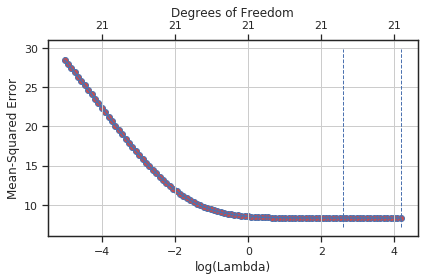

In [115]:
f = plt.figure(figsize=(6,4))
#f.add_subplot(2,2,1)
cvglmnetPlot(cvfit)


plt.tight_layout()

#### iterate over trials

In [118]:

alpha = 0 # 1 is lasso, 0 is ridge 


tau_stim = 11#tau
tau_r = 10
#tau = 10

s=[0.02]

x = []
y = []
fit = []
coeff = []

for trialnr in range(4):
    
    
    rialnr = 1
 
    
    # get stim component
    ## including the current stimulus to predict (present)
    x_stim = get_datax_new(stim_binary_binned, tau_stim)

    # get release component
    ## only including the past
    # taking one data trace
    x_r = get_datax_new(r_binary[trialnr], tau_r)[:-1] # [:,tau-tau_r:]
   
    x.append(np.hstack([x_stim, x_r]))

    # taking one data trace
    y.append(np.array(r_binary[trialnr])[tau_stim:])
    
    """
    fit the model
    """
    #offset = np.ones(len(y))
    #alpha = 0 # 1 is lasso, 0 is ridge 

    fit.append(glmnet(x = x[trialnr].copy(), y = y[trialnr].copy(), family = 'poisson', alpha=alpha))
    
    coeff.append(glmnetCoef(fit[trialnr], s = scipy.float64([s[0]]), exact = False))

In [119]:
coeff = []

for trialnr in range(4):

    #s = [0.01]
    coeff.append(glmnetCoef(fit[trialnr], s = scipy.float64([s[0]]), exact = False))

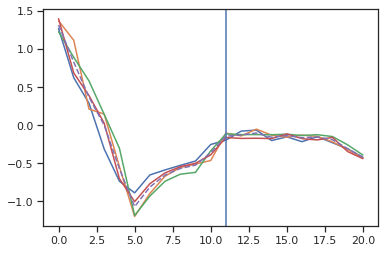

In [121]:
for i in range(4):
    plt.plot(coeff[i][1:])
    
plt.plot(np.mean(coeff, axis=0)[1:], '--')

plt.axvline(tau_stim)

    
#plt.plot(coeff_mean, '--',color='r')

In [123]:
def predict_one(fit, x,tau_stim=11, tau_r=10, s=[0.02] ):
    """
    fit: fitted glm 
    x: data used to fit glm (needed for initialization)
    tau: timesteps to include 
    s: lambda value for glm
    """
    # define variables
    release_pred = np.zeros(len(r_binary[0])-tau_stim)
    rate_pred = np.zeros(len(release_pred))

    # get initial prediction
    init_predict =  glmnetPredict(fit, 
                       x.copy()[:tau_stim],
                       #offset= offset.T,
                       ptype = 'response',
                       s = scipy.float64([s[0]]))

    # initialize rate and release (based on experimental, without history effect)
    rate_pred[:tau] = init_predict[0]
    release_pred[:tau] = scp.stats.poisson.rvs(rate_pred[:tau])



    # iterate over time
    for t in range(tau_stim, len(release_pred)):
        # define x taking actual release
        x_temp_stim = x[t,:tau_stim]
        x_temp_release = release_pred[t-tau_r:t]#[::-1] # invert to same direction as in training
        x_temp = np.hstack([x_temp_stim, x_temp_release])

        # predict rate
        rate_pred[t] =  glmnetPredict(fit, 
                                       np.array([x_temp]),
                                       #offset= offset.T,
                                       ptype = 'response',
                                       s = scipy.float64([s[0]]))

        # sample from poisson
        release_pred[t] = scp.stats.poisson.rvs(rate_pred[t])
        
    return release_pred


In [125]:
"""
run multiple evaluation

m simulations for each fit trialnr/nfit
"""

m = 4
nfit = 4


predictions = np.ones((nfit,m, len(y[0])))

for trialnr in range(nfit):
    for i in range(m):
        predictions[trialnr, i] = predict_one(fit[trialnr], x[trialnr], s=s, tau_r=tau_r, tau_stim=tau_stim)
    print('finished trialnr:', trialnr)



finished trialnr: 0
finished trialnr: 1
finished trialnr: 2
finished trialnr: 3


In [160]:
"""
flatten and choose predictions
"""
nr_per_trial = 3
nr_trials = 4

predictions_flatten = []

for i in range(nr_trials):
    for j in range(nr_per_trial):
        predictions_flatten.append(predictions[i,j])
        
predictions_flatten = np.array(predictions_flatten)

"""
save predictions
"""

import pickle

dictname={'glm_predictions':predictions_flatten}

with open("glm_predictions.pkl", "wb") as f:
    pickle.dump(dictname, f)


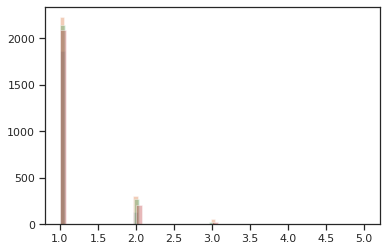

In [127]:
for i in range(nfit):
    sns.distplot(predictions[i][predictions[i]>0], kde=False)

In [136]:
"""
specify summary stats

for n>1
"""

data=r_binary[:,tau:-2]

nSS = 9


## specify kernel to compare traces
g = scipy.signal.gaussian(10,2)


# number of recorded traces
nTrue = len(data)

lenData = len(data[0])
trueG = np.zeros((nTrue,lenData+len(g)-1))

for i in range(nTrue):
    trueG[i,:] = scipy.signal.convolve(data[i],g)
  

# specify weights for summary stats
unweighted_data_SS = makeSS(data,g,trueG, w = np.ones(nSS))
# normalizing factor
w_norm = 1/unweighted_data_SS
w_norm[np.isinf(w_norm)] = 1/48 #(1/48 mean value for the recorded traces)
#scaling factor for each sums stat
w_scale =  np.ones(len(unweighted_data_SS))
w_scale[0] = 5 # conv
w_scale[1] = 5 # sum of all
w_scale[2] = 5 # 1-fold
w_scale[3] = 5 # 2-fold
w_scale[4] = 2 # 4-fold
w_scale[5] = 2 # 5 fold
w_scale[6] = 4 # 6 fold
w_scale[7] = 2 # std

# final w 
w = w_norm * w_scale

dataSS = makeSS(data,g,trueG,w)


    
    
    
 

In [137]:

def plot_event_histo(data,  sumstatnames = ['1-q','2-q','3-q','4-q','5-q','6-q','7-q' ],
                     color='b',
                    alpha=1,
                    errcolor='black',
                    label=None):
    """
    :param data: array (ntraces, release)
    :param figsize:
    :param sumstatnames:
    :param color:
    :param alpha:
    :param errcolor:
    :return:
    """

    dn = np.zeros((len(data),7))
    for i in range(len(data)):
        #dn[i,0]= np.sum(data[i])
        for j in range(0,7):
            dn[i,j]= np.sum(data[i]==j+1)

    df = pd.DataFrame(dn)

    df.columns = sumstatnames
    


    #sns.set_context("notebook")
    #sns.set_style("white")


    #plt.figure(1, figsize=(10,6))
    ax = sns.barplot( data=df,  ci='sd',capsize=.2, errwidth=2, estimator=np.mean,
                     color=color,
                     alpha=alpha,
                     errcolor=errcolor,
                    label=label)
    plt.xlabel('event type')
    plt.ylabel('count')
    plt.legend()
    sns.despine()


def plot_pairwise_loss_comparison(data, fit,w, colordata='r', colorfit='b', alpha=0.5):
    g = scp.signal.gaussian(10, 2)

    fitloss = pairwise_loss(data, g, w, mode='fit', fit=fit)
    dataloss = pairwise_loss(data, g, w, mode='data')
    
    sns.set_style('ticks')
    # data
    df = pd.DataFrame(dataloss)
    df.columns = [None]
    ax = sns.barplot(data=df, ci='sd', capsize=.2, errwidth=2, estimator=np.mean,
                     color=colordata,
                     alpha=alpha,
                     errcolor='r',
                     label='data')

    # fit
    df = pd.DataFrame(fitloss)
    df.columns = [None]
    ax = sns.barplot(data=df, ci='sd', capsize=.2, errwidth=2, estimator=np.mean,
                     color=colorfit,
                     alpha=alpha,
                     errcolor='b',
                     label='fit')

    sns.despine()
    plt.xlabel('discrepancy')
    
    print(fitloss)


def plot_event_loss_histo_comprison(data, fit,w, alpha=0.5, label='data', color='r', errcolor='r'):
    plt.figure(1, figsize=(6, 3))

    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 1])
    ax0 = plt.subplot(gs[0])
    # plt.subplot(121)
    plot_event_histo(data, alpha=0.5, label='data', color='r', errcolor='r')
    plot_event_histo(fit, alpha=0.5, label='fit', color='b', errcolor='b')
    ax1 = plt.subplot(gs[1])
    plot_pairwise_loss_comparison(data, fit,w)

# plot_event_loss_histo_comprison(data,fit)

"""
new version: "pairwise loss"
rest vs 1


TAKE THIS AS BEST APPROXIMATION TO MEAN
"""


def pairwise_loss(data, g, w, mode, fit=None):
    """
    calculates the all-1 vs one
    if mode=data: between data traces ( mean of all-1 vs one)
    if mode=fit: between data and fit (mean data vs one fit)
    """
    w = np.copy(w)
    #w[0] = 0.062
    w[-1] = 0
    nsumstats = 9
    if mode == 'data':
        fitSS = np.zeros((len(data), nsumstats))
        dists = np.zeros(len(data))
        trueG = np.zeros((len(data) - 1, len(data[0]) + len(g) - 1))

        for i in range(len(data)):
            a = list(range(len(data)))
            a.pop(i)

            count = 0
            for j in a:  # all data except one (i-th)
                trueG[count] = scipy.signal.convolve(data[j], g)
                count += 1
            dataSS = makeSS(data[np.arange(len(data)) != i], g, trueG, w)
            # print(dataSS)
            fitSS[i] = makeSS(data[i], g, trueG, w)
            # print(fitSS[i])
            # print()
            dists[i] = scipy.spatial.distance.euclidean(fitSS[i], dataSS)



    elif mode == 'fit':
        fitSS = np.zeros((len(fit), nsumstats))
        dists = np.zeros(len(fit))
        trueG = np.zeros((len(data), len(data[0]) + len(g) - 1))

        for i in range(len(data)):
            trueG[i, :] = scipy.signal.convolve(data[i], g)
        for i in range(len(fit)):
            # trueG = scipy.signal.convolve(data,g)
            dataSS = makeSS(data, g, trueG, w)
            #print(dataSS)
           # print(w)
            fitSS[i] = makeSS(fit[i], g, trueG, w)  # take all fitted traces
            # print(fitSS[i])
            # print()
            dists[i] = scipy.spatial.distance.euclidean(fitSS[i], dataSS)

    else:
        print('this mode is not yet implemented. choose fit or data.')

    return dists




'\ndef pairwise_loss(data,g, w, mode, fit=None):\n    """\n    calculates the all-1 vs one\n    if mode=data: between data traces ( 1 vs rest, iterating over data)\n    if mode=fit: between data and fit (1 data, vs rest, iterating over data)\n    """\n    w = np.copy(w)\n \n    nsumstats=9\n    if mode==\'data\':\n        nr_pairs = int(scp.special.binom(len(data),2))\n        dists = np.zeros(nr_pairs)\n        \n        count=0\n        for i in range(len(data)):\n            for j in range(i+1,len(data)):\n                trueG = scipy.signal.convolve(data[i],g)\n                dataSS = makeSS(data[i],g,trueG,w)\n                #print(dataSS)\n                fitSS = makeSS(data[j], g, trueG,w) \n                #print(fitSS)\n                #print()\n                dists[count] = scipy.spatial.distance.euclidean(fitSS, dataSS)\n                count+=1\n\n        \n    elif mode==\'fit\':   \n        nr_pairs = len(data)*len(fit)\n        dists = np.zeros(nr_pairs)\n        \n 

[16.77280618 14.71669694 15.67570931 14.97515755]


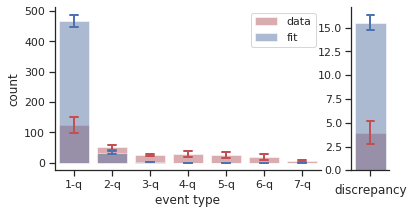

In [141]:
"""
show result for one fitted trial
"""

nfit = 0

w_scale_one = np.ones(9)

w = w_norm * w_scale


plot_event_loss_histo_comprison(data,predictions[nfit], w)


[16.77280618 19.02662376 18.47250922 17.2746211 ]


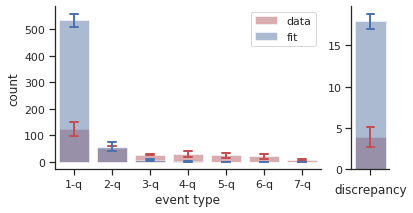

In [142]:
"""
take one simulation of each fit
"""

sim_nr = 0

w_scale_one = np.ones(9)

w = w_norm * w_scale


plot_event_loss_histo_comprison(data,predictions[:,sim_nr], w)


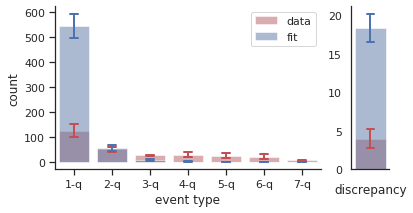

In [25]:
"""
take one simulation of each fit
"""

sim_nr = 0

w_scale_one = np.ones(9)

w = w_norm * w_scale


plot_event_loss_histo_comprison(data,predictions[:,sim_nr], w)


filepath =  "/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/model_Ben/switching-git/NeurIPS/plots/baseline_model"
filename = 'sumstats_baseline.svg'
plt.savefig(filepath + filename, dpi=300, format='svg')    


[16.42522615 21.27348883 17.69978452 18.00082586]


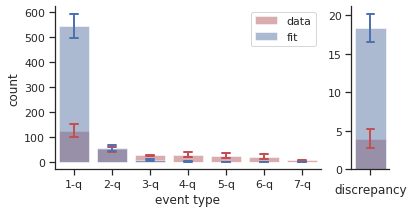

In [90]:
"""
take one simulation of each fit
"""

sns.set_style('ticks')

sim_nr = 0

w_scale_one = np.ones(9)

w = w_norm * w_scale


plot_event_loss_histo_comprison(data,predictions[:,sim_nr], w)


filepath =  "/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/model_Ben/switching-git/NeurIPS/plots/baseline_model"
filename = 'sumstats_baseline.svg'
plt.savefig(filepath + filename, dpi=300, format='svg')    


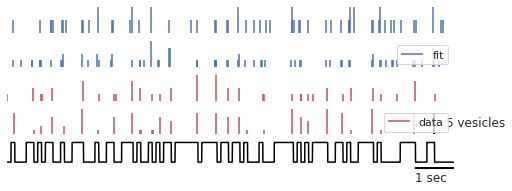

In [26]:

predictions_n = predictions[1]

sns.set_context("notebook")
S0 = 5000
S = 6170

t_plot = np.arange(0, S*10-S0*10)/1000

plt.figure(1, figsize=(8,3)) # 10 4

# plot fitted
yscalebar=False
count=0
for i in [1,2]: # [6,2]
    ax=plt.subplot(5,1,count+1)
    if i==0:
        yscalebar=True
    plot_raster1_new(ax,predictions_n[i,S0:S],  color='b',  label='fit', scalebar=yscalebar, scalebarcolor='black')
    yscalebar=False
    count+=1

plt.legend()

# plot data traces
yscalebar=False
count=0
for i in [0,1]: #0,3
    ax=plt.subplot(5,1,count+2+1)
    if count==1:
        yscalebar=True
    plot_raster1_new(ax,data[i,S0:S],  color='r',  label='data', scalebar=yscalebar, scalebarcolor='black')
    count+=1
plt.legend()

# plot stimulus
ax=plt.subplot(5,1,5)
plt.plot(t_plot, light[S0*10:S*10], color='black')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xlim(t_plot[0], t_plot[-1])

#sns.despine()
plt.yticks([])
plt.xticks([])
#plt.xlabel('sec')

#scalebar
scalebar = np.ones(len(t_plot)) * (-0.3)
for i in range(len(scalebar)):
    if i>len(scalebar) or i<len(scalebar)-1000: # 1 tpt is 1ms => 1000 = 1sec
        scalebar[i] = np.nan

plt.plot(t_plot, scalebar, linewidth=2, color = 'black' )
plt.text(t_plot[-1]-1,-0.95,'1 sec')


filepath =  "/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/model_Ben/switching-git/NeurIPS/plots/baseline_model"
filename = 'raster_baseline.svg'
plt.savefig(filepath + filename, dpi=300, format='svg')    


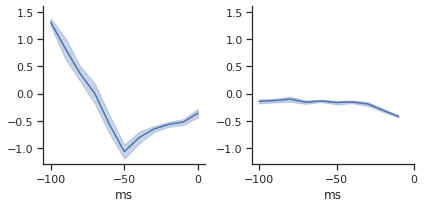

In [162]:
# calc mean and std, excluding first offset beta_0
coeff_std = np.std(coeff, axis=0).flatten()[1:]#[::-1]
coeff_mean = np.mean(coeff, axis=0).flatten()[1:]#[::-1]
    
t_stim = -np.arange(tau_stim)*10 #- 0.01
t_r = -np.arange(1,tau_r+1)*10 #- 0.01


plt.figure(1, figsize=(6, 3))

plt.subplot(121)
# plot weights for stimulus
plt.fill_between(t_stim,
                 coeff_mean[:tau_stim][::-1]+coeff_std[:tau_stim][::-1],
                 coeff_mean[:tau_stim][::-1]-coeff_std[:tau_stim][::-1],
                 alpha=0.3,
                 color='b', label='+-1std')
    
plt.plot(t_stim, coeff_mean[:tau_stim][::-1], color='b')
plt.ylim(-1.3,1.6)
plt.xlabel('ms')



plt.subplot(122)
# plot weights for spike history
plt.fill_between(t_r,
                 coeff_mean[-tau_r:][::-1]+coeff_std[-tau_r:][::-1],
                 coeff_mean[-tau_r:][::-1]-coeff_std[-tau_r:][::-1],
                 alpha=0.3,
                 color='b', label='+-1std')
    
plt.plot(t_r, coeff_mean[-tau:][::-1], color='b')
plt.ylim(-1.3,1.6)
plt.xlabel('ms')
plt.xticks([-100,-50,0])

plt.tight_layout()

sns.despine()

#plt.plot(t, coeff[0][1:11], color='r')

filepath =  "/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/model_Ben/switching-git/NeurIPS/plots/baseline_model/"
filename = 'weights_baseline_0819.svg'
plt.savefig(filepath + filename, dpi=300, format='svg')    


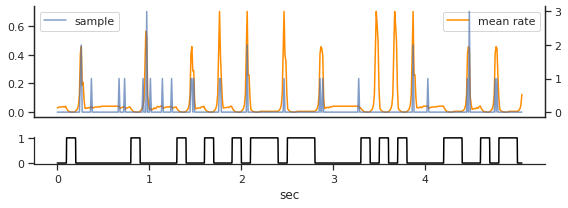

In [163]:
S0= 1600#1150
S = 2105#1592

t = np.arange(S*10-S0*10)/1000

sns.set_style('ticks')

plt.figure(1, figsize=(8,3))


gs = gridspec.GridSpec(2, 1,height_ratios =[4, 1])
ax0_0 = plt.subplot(gs[0])

#plt.plot(r_binary[0][S0+tau: S+tau], color='r', label='data', alpha=1)
ax0_0.plot(rate_pred[S0:S], color='darkorange',label='mean rate')

plt.legend()

#plt.yticks([0,1])
plt.xticks([])

#combine axis
ax0_1 = ax0_0.twinx()
ax0_1.plot(release_pred[S0:S], label='sample', color='b', alpha=0.7)

ax0_1.spines['top'].set_visible(False)
ax0_0.spines['top'].set_visible(False)

plt.legend()
################################################
ax1 = plt.subplot(gs[1])
#ax0_0.plot(stim_binary_binned[S0+tau: S+tau],color='black' ,alpha=1, label='stimulus')
ax1.plot(t,stim_binary[S0*10+tau*10: S*10+tau*10],color='black' ,alpha=1, label='stimulus')



'''
#scalebar
scalebar = np.ones(len(t)) * (-0.3)
for i in range(len(scalebar)):
    if i>len(scalebar) or i<len(scalebar)-1000: # 1 tpt is 1ms => 1000 = 1sec
        scalebar[i] = np.nan

plt.plot(t, scalebar, linewidth=2, color = 'black' )
plt.text(t[-1]-1,-0.95,'1 sec')
'''

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)

plt.xticks([0,1,2,3,4])
#plt.yticks([])
#sns.despine()
plt.xlabel('sec')


plt.tight_layout()

#plt.ylim(0,2)


filepath =  "/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/model_Ben/switching-git/NeurIPS/plots/baseline_model/"
filename = 'predicted_rate_baseline_0819.svg'
plt.savefig(filepath + filename, dpi=300, format='svg')   

